# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

El caso de uso que se busca cubrir hace referencia a detectar si una jugada termina en home run o no, cuando la bola ya fue bateada. Solo se va a poder usar dicho modelo para predecir el resultado de una jugada si se tienen los datos del lanzamiento y el bateo. En consecuencia, podemos decir que su principal uso puede relacionarse con el estudio y análisis de las mejores formas para realizar un home run

A partir del dataset elegido y ya preprocesado con la lógica definida en el TP1, el grupo debe realizar el entrenamiento y evaluación de al menos 3 algoritmos de machine learning.

   Se debe elegir y definir una métrica de performance a utilizar para evaluar los modelos. Fundamentar la elección de la métrica.
   Se debe aplicar alguna técnica de feature engineering para mejorar los datos de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.
   Por cada modelo, se debe entrenarlo y realizar una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los hiper-parámetros que mejores resultados ofrecen. En caso de ser posible, aporte conclusiones respecto a dicha comparación.
   Realizar experimentos que utilicen como datos de entrada representaciones intermedias de los datos (generadas por técnicas de reducción de dimensiones como PCA). Compare los resultados obtenidos contra los casos previos, interprete y proponga conclusiones.
   Se deben utilizar técnicas que garanticen que los modelos no están sobreentrenando sin que nos demos cuenta.
   Determinar el valor final de la métrica que podría ser informado al cliente, utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar y considerar no solo el rendimiento del modelo en su elección, sino también cuestiones como interpretabilidad, tiempos de entrenamiento, etc.
   Para el método propuesto como definitivo, y para distintos pares de variables, genere diagramas de dispersión donde se visualicen los aciertos y errores del mismo. Discuta si existen patrones o conocimiento que se pueda obtener a partir de dichos errores. En caso de ser posible, evalúe la importancia que asigna el método a las variables de entrada y genere conclusiones al respecto.


## Tratamiento de datos aplicados en el trabajo práctico N.º 1

In [123]:
# Importamos las dependencias necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import QuantileTransformer
warnings.filterwarnings('ignore')

In [3]:
# Arreglamos el dataset según lo establecido en el TP1

# Importamos train.csv y park_dimensions.csv, los unimos utilizando la variable "park"
entrenamiento = pd.read_csv('./train.csv')
estadio = pd.read_csv('./park_dimensions.csv')
completa=entrenamiento.merge(estadio, on="park", how="left")

# Desechamos las variables no utilizadas
completa = completa.drop(['park','bip_id','batter_id','pitcher_id'],axis=1)

# Asignamos nuevos nombres a las columnas
renamed_columns = {'NAME': 'name', 'Cover': 'cover', 'LF_Dim': 'lf_dim', 'CF_Dim':'cf_dim',
                   'RF_Dim': 'rf_dim', 'LF_W': 'lf_w', 'CF_W': 'cf_w', 'RF_W': 'rf_w'
                  }
completa.rename(columns=renamed_columns, inplace=True)

# Convertir columna "game_date" de tipo object/string, a datetime
completa['game_date'] = pd.to_datetime(completa['game_date'])

# Eliminar datos filas con datos nulos en bb_type
completa = completa[~completa.bb_type.isnull()]

# Delimitación de conjuntos
completa.isnull().sum()

# Crear df a la que se le va aplicar feature engineering
completa_fe = completa
columnas_string=['game_date', 'batter_team','batter_name','pitcher_name','name']
completa_fe = completa_fe.drop(columnas_string,axis=1)

# Eliminar columnas cuyos valores sean cadenas
columnas_string=['home_team','away_team', 'game_date', 'batter_team','batter_name','pitcher_name','name']
completa = completa.drop(columnas_string,axis=1)

## División del dataset

In [4]:
# Dividimos el dataset en train (60%), test (20%) y validation (20%)
from sklearn.model_selection import train_test_split

train, not_train = train_test_split(completa, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((27742, 22), (9248, 22), (9248, 22))

In [136]:
# Definimos el mapper. Recibe una lista de (columna/s, transformers)

mapper = DataFrameMapper([ 
    (['is_batter_lefty'], None),#
    (['is_pitcher_lefty'], None),#
    (['bb_type'], [OneHotEncoder()]),#
    (['bearing'], [OneHotEncoder()]),#
    (['pitch_name'], [OneHotEncoder()]),#
    (['inning'], [StandardScaler()]),#
    (['outs_when_up'], None),#
    (['balls'], [StandardScaler()]),#
    (['strikes'], [StandardScaler()]),#
    (['plate_x'], [StandardScaler()]),#
    (['plate_z'], [StandardScaler()]),#
    (['pitch_mph'], [StandardScaler()]),
    (['launch_speed'], [StandardScaler()]),
    (['launch_angle'], [StandardScaler()]),
    (['cover'], [OneHotEncoder()]),#
    (['lf_dim'], [StandardScaler()]),
    (['cf_dim'], [StandardScaler()]),
    (['rf_dim'], [StandardScaler()]),
    (['lf_w'], [StandardScaler()]),
    (['cf_w'], [StandardScaler()]),
    (['rf_w'], [StandardScaler()]),
])

train_nor=train
mapper.fit(train_nor)

#train_p= mapper.transform(train_nor)
#completa_processed = pd.DataFrame(completa_processed, columns=mapper.transformed_names_)
#completa_processed
#mapper.transformed_names_
#completa_processed.isnull().sum()

DataFrameMapper(drop_cols=[],
                features=[(['is_batter_lefty'], None),
                          (['is_pitcher_lefty'], None),
                          (['bb_type'], [OneHotEncoder()]),
                          (['bearing'], [OneHotEncoder()]),
                          (['pitch_name'], [OneHotEncoder()]),
                          (['inning'], [StandardScaler()]),
                          (['outs_when_up'], None),
                          (['balls'], [StandardScaler()]),
                          (['strikes'], [StandardScaler()]),
                          (['plate_x'], [StandardScaler()]),
                          (['p...], [StandardScaler()]),
                          (['pitch_mph'], [StandardScaler()]),
                          (['launch_speed'], [StandardScaler()]),
                          (['launch_angle'], [StandardScaler()]),
                          (['cover'], [OneHotEncoder()]),
                          (['lf_dim'], [StandardScaler()]),
                          (['cf_dim'], [StandardScaler()]),
                          (['rf_dim'], [StandardScaler()]),
                          (['lf_w'], [StandardScaler()]),
                          (['cf_w'], [StandardScaler()]),
                          (['rf_w'], [StandardScaler()])])

## Selección de métrica

Se debe elegir y definir una métrica de performance a utilizar para evaluar los modelos. Fundamentar la elección de la métrica.

Con respecto a las métricas, podemos decir que vamos a utilizar recall y precisión. Esto se debe a que los datos están muy desbalanceados, y en consecuencia accuracy no sería la mejor opción porque presentaría problemas.

 - Recall nos va a permitir ver de todos los Foo que había, cuántos encontramos.

 - Precisión que nos va a permitir ver de lo que clasificamos como Foo, qué porcentaje era realmente Foo.

## Aplicaciones de featuring engineering

En lo referente a feature enginering hay que hay que mencionar que vamos a aplicar la técnica de QuantileTransformer para las variables de entrada que tienen valores extremos según lo observado en el TP1. De esta forma se logra reducir el impacto de los valores atípicos. También vamos a transformar algunas variables para transformar la información de las mismas expresada de otra forma. 
Aplicamos técnicas de preprocesado para mejorar la representación de los datos como OneHotEncoder y StandardImputer, y eliminamos los valores nulos utilizando SimpleImputer.

### Extraer features a partir de otras

#### Agrupar equipos por regiones

In [6]:
east = ['TB','BAL','BOS','TOR','NYY','ATL','MIA','PHI','NYM','WSH']
central = ['MIN','CLE','DET','CWS','KC','PIT','MIL','CHC', 'CIN', 'STL']
west = ['TEX','LAA','HOU','SEA','OAK','LAD','SD','SF','COL','ARI']

def division_h(row):
    if east.count(row['home_team']) > 0:
        return 'east'
    else:
        if central.count(row['home_team']) > 0:
            return 'central'
        else:
            return 'west'
        
def division_a(row):
    if east.count(row['away_team']) > 0:
        return 'east'
    else:
        if central.count(row['away_team']) > 0:
            return 'central'
        else:
            return 'west'
        
division_home = completa_fe.apply(division_h, axis=1)
division_away = completa_fe.apply(division_a, axis=1)
completa_fe["division_home"] = division_home
completa_fe["division_away"] = division_away
completa_fe.sample(10)
#completa_fe[["division_away",'away_team']]

# Eliminar columnas que ya no son necesarias
columnas_string=['home_team','away_team']
completa_fe = completa_fe.drop(columnas_string,axis=1)

### Aplicación de QuantileTransformer

Según lo visto en el TP1, consideramos necesario verificar si esta técnica debe aplicarse a las variables "plate_x", "plate_z", "pitch_mph", "launch_speed" y "launch_angle". Esto se debe a que contienen valores extremos que pueden traer problemas para la predicción.

In [7]:
# Función para graficar transformaciones de datos
def plots(df, col, t):
    plt.figure(figsize=(12,4))
    
    plt.subplot(121)
    sns.kdeplot(df[col])
    plt.title('Antes de aplicar ' + str(t).split('(')[0])

    plt.subplot(122)
    p1 = t.fit_transform(df[[col]]).flatten()
    sns.kdeplot(p1)
    plt.title('Después de aplicar ' + str(t).split('(')[0])

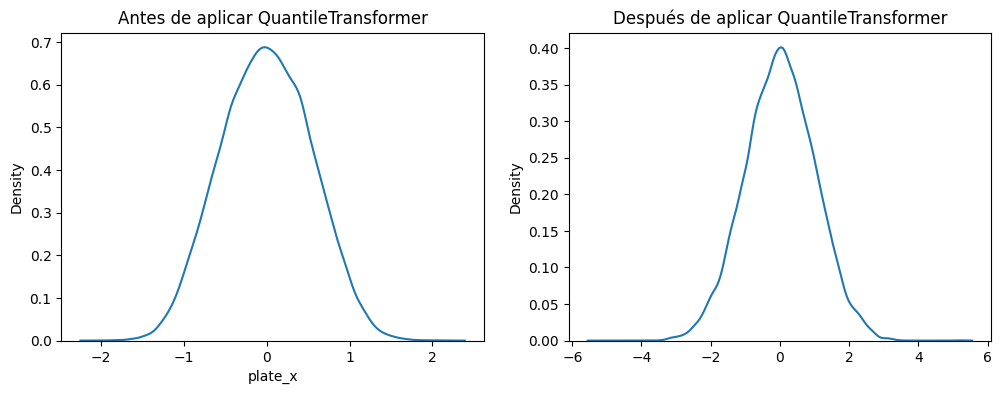

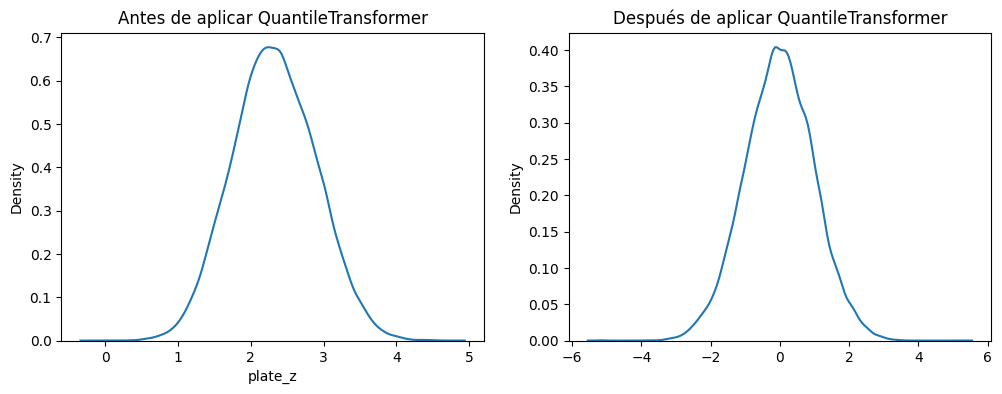

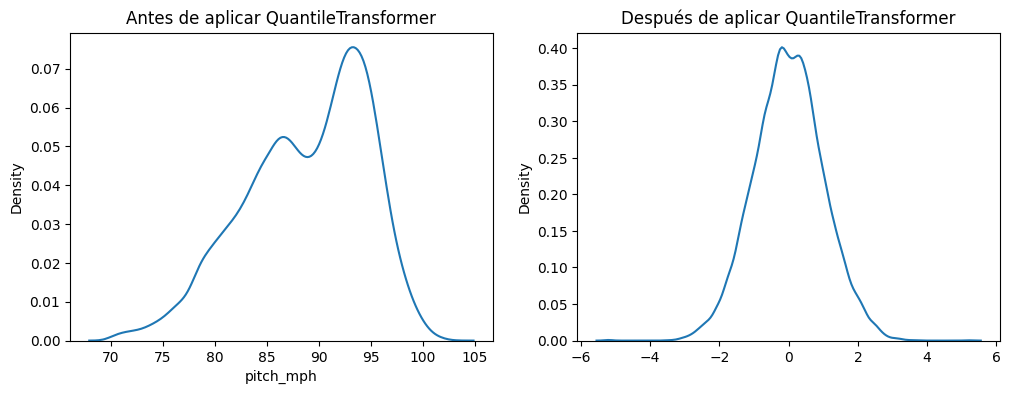

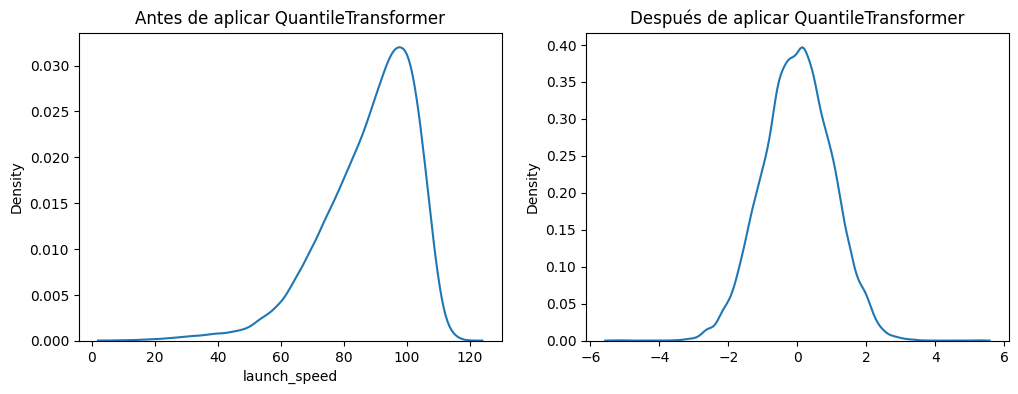

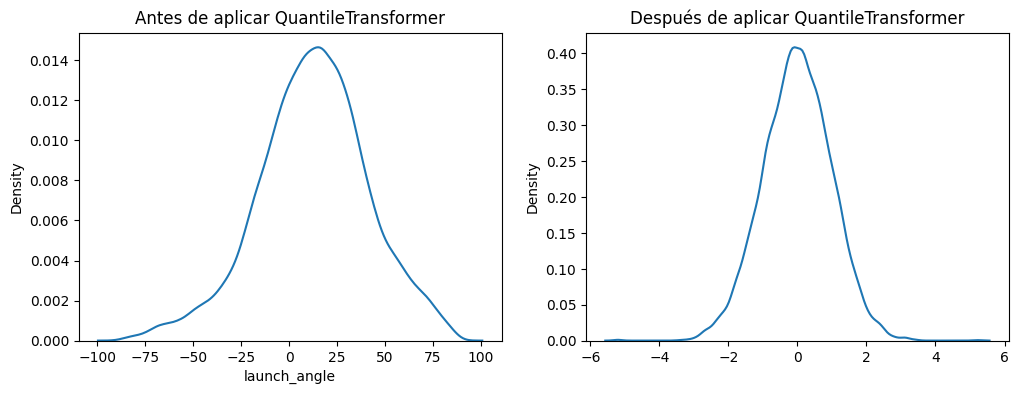

In [8]:
qt = QuantileTransformer(output_distribution='normal')

# Graficar variables candidatas a aplicar Quantile Transformation
columns_qt = ['plate_x', 'plate_z', 'pitch_mph', 'launch_speed', 'launch_angle']
for col in columns_qt:
    plots(completa_fe, col, qt)

Como podemos visualizar en las gráficas, existen variables que ya presentan una distribución normal, mientras que otras presentan otro tipo de distribución.

Es por ello, que decidimos aplicar la técnica en aquellas variables que lo requieren, como pitch_mph y launch_speed.

In [9]:
# Reemplazamos columnas
completa_fe['pitch_mph_qt'] = qt.fit_transform(completa_fe.pitch_mph.to_frame())
completa_fe['launch_speed_qt'] = qt.fit_transform(completa_fe.launch_speed.to_frame())

completa_fe = completa_fe.drop(['pitch_mph', 'launch_speed'],axis=1)

### División del dataset con feature engineering

In [10]:
# Dividimos el dataset aplicando feature engine en train (60%), test (20%) y validation (20%)
train_fe, not_train_fe = train_test_split(completa_fe, test_size=0.4, random_state=42)
validation_fe, test_fe = train_test_split(not_train_fe, test_size=0.5, random_state=42)

train_fe.shape, validation_fe.shape, test_fe.shape

((27742, 24), (9248, 24), (9248, 24))

In [137]:
# Definimos el mapper. Recibe una lista de (columna/s, transformers)

mapper_fe = DataFrameMapper([ 
    (['is_batter_lefty'], None), #
    (['is_pitcher_lefty'], None), #
    (['bb_type'], [OneHotEncoder()]), #
    (['bearing'], [OneHotEncoder()]), #
    (['pitch_name'], [OneHotEncoder()]), #
    (['inning'], [StandardScaler()]), #
    (['outs_when_up'], None), #
    (['balls'], [StandardScaler()]), #
    (['strikes'], [StandardScaler()]), #
    (['plate_x'], [StandardScaler()]), #
    (['plate_z'], [StandardScaler()]), #   
    (['launch_angle'], [StandardScaler()]),
    (['cover'], [OneHotEncoder()]),#
    (['lf_dim'], [StandardScaler()]),
    (['cf_dim'], [StandardScaler()]),
    (['rf_dim'], [StandardScaler()]),
    (['lf_w'], [StandardScaler()]),
    (['cf_w'], [StandardScaler()]),
    (['rf_w'], [StandardScaler()]),
    (["division_home"], [OneHotEncoder()]),
    (["division_away"], [OneHotEncoder()]),
    (['pitch_mph_qt'], [StandardScaler()]),
    (['launch_speed_qt'], [StandardScaler()]),
])

mapper_fe.fit(train_fe)

DataFrameMapper(drop_cols=[],
                features=[(['is_batter_lefty'], None),
                          (['is_pitcher_lefty'], None),
                          (['bb_type'], [OneHotEncoder()]),
                          (['bearing'], [OneHotEncoder()]),
                          (['pitch_name'], [OneHotEncoder()]),
                          (['inning'], [StandardScaler()]),
                          (['outs_when_up'], None),
                          (['balls'], [StandardScaler()]),
                          (['strikes'], [StandardScaler()]),
                          (['plate_x'], [StandardScaler()]),
                          (['p...
                          (['cover'], [OneHotEncoder()]),
                          (['lf_dim'], [StandardScaler()]),
                          (['cf_dim'], [StandardScaler()]),
                          (['rf_dim'], [StandardScaler()]),
                          (['lf_w'], [StandardScaler()]),
                          (['cf_w'], [StandardScaler()]),
                          (['rf_w'], [StandardScaler()]),
                          (['division_home'], [OneHotEncoder()]),
                          (['division_away'], [OneHotEncoder()]),
                          (['pitch_mph_qt'], [StandardScaler()]),
                          (['launch_speed_qt'], [StandardScaler()])])

In [ ]:
train_fe.sample(10)

## Modelos a utilizar

Los modelos que vamos a utilizar van a ser:
 - LogisticRegression
 - KNeighborsClassifier
 - GridSearchCV
 - RandomForestClassifier
 
  Por cada modelo, se debe entrenarlo y realizar una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los hiper-parámetros que mejores resultados ofrecen. En caso de ser posible, aporte conclusiones respecto a dicha comparación.

In [32]:
def evaluate_model(model, set_names=('train_nor', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train_nor', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.is_home_run
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['Es', 'No es'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))
    
    
    
    
def evaluate_model_fe(model, set_names=('train_fe', 'validation_fe'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train_fe', 'validation_fe', 'test_fe']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.is_home_run
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['Es', 'No es'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

In [151]:
#Grid Search: Gradient Boosting

e_range = [10, 20, 50]
param_grid = dict(n_estimators=e_range)

clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring= 'precision',refit=True,verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train_nor, train_nor.is_home_run)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.8105558041389056, {'n_estimators': 10})

In [156]:
#Grid Search: KNN
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 31))
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range)

clf = GridSearchCV(knn, param_grid, refit=True,verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train_nor, train_nor.is_home_run)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


(0.9459664004101624, {'n_neighbors': 21})

In [157]:
#Grid Search:Árbol con profundidad
from sklearn.model_selection import GridSearchCV

profundidad = list(range(2, 20))
tree = tree_model_limit
param_grid = dict(max_depth=profundidad)

clf = GridSearchCV(tree, param_grid, refit=True,verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train_nor, train_nor.is_home_run)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


(0.9583664925044142, {'max_depth': 6})

In [158]:
#Grid Search: Random Forest

parameters = {'n_estimators': [100, 200], 
              'max_depth':[3, 5, 8],
              'max_features': [2, 5]}

clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train_nor, train_nor.is_home_run)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


(0.9527792376835956, {'max_depth': 8, 'max_features': 5, 'n_estimators': 200})

In [148]:
from sklearn import metrics

# Aplicación Gradient boosting

modelGradBoost10 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', GradientBoostingClassifier(n_estimators=10, random_state=42))
])
modelGradBoost10.fit(train_nor, train_nor.is_home_run)
evaluate_model(modelGradBoost10, title='Gradient Boosting with n_trees=10')

#Aplicación Gradient boosting

modelGradBoost10_fe = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', GradientBoostingClassifier(n_estimators=10, random_state=42))
])
modelGradBoost10_fe.fit(train_fe, train_fe.is_home_run)
evaluate_model_fe(modelGradBoost10_fe, title='Gradient Boosting with n_trees=10')

'Gradient Boosting with n_trees=10'

,Accuracy,Precision,Recall,F1
train_nor,0.956312,0.788955,0.265781,0.397614
validation,0.958478,0.751825,0.227373,0.349153


'Gradient Boosting with n_trees=10'

,Accuracy,Precision,Recall,F1
train_fe,0.954906,0.875740,0.196678,0.321215
validation_fe,0.958694,0.851485,0.189845,0.310469


In [149]:
# Aplicación knn

K=21
knn_model = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train_nor, train_nor.is_home_run)
y_pred = knn_model.predict(validation)
y_pred

evaluate_model(knn_model, title='KNN')

#Aplicación knn y fe

knn_model_fe = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model_fe.fit(train_fe, train_fe.is_home_run)
y_pred = knn_model_fe.predict(validation_fe)
y_pred

evaluate_model_fe(knn_model_fe, title='KNN')


'KNN'

,Accuracy,Precision,Recall,F1
train_nor,0.946219,0.933333,0.009302,0.018421
validation,0.951233,1.000000,0.004415,0.008791


'KNN'

,Accuracy,Precision,Recall,F1
train_fe,0.946399,0.909091,0.013289,0.026195
validation_fe,0.951449,0.750000,0.013245,0.026030


In [79]:
#Aplicación árbol con profundidad limitada

tree_model_limit = DecisionTreeClassifier(max_depth=6, random_state=42)

dt_model_limit = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model_limit),
])

dt_model_limit.fit(train_nor, train_nor.is_home_run)

evaluate_model(dt_model_limit, title='Decision Tree with depth limit')

# Aplicación árbol con profundidad limitada y fe

tree_model_limit = DecisionTreeClassifier(max_depth=6, random_state=42)

dt_model_limit = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model_limit),
])

dt_model_limit.fit(train_fe, train_fe.is_home_run)

evaluate_model_fe(dt_model_limit, title='Decision Tree with depth limit')

'Decision Tree with depth limit'

,Accuracy,Precision,Recall,F1
train_nor,0.957429,0.753918,0.319601,0.448903
validation,0.958802,0.697802,0.280353,0.400000


'Decision Tree with depth limit'

,Accuracy,Precision,Recall,F1
train_fe,0.961250,0.761557,0.415947,0.538032
validation_fe,0.960424,0.669261,0.379691,0.484507


In [159]:
#APlicación random forest

forest_model = RandomForestClassifier(max_depth= 8, max_features= 5, n_estimators=200, random_state=42)

rf_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train_nor, train_nor.is_home_run)

evaluate_model(rf_model, title='Random Forest')

#Aplicación random forest con fe

forest_model = RandomForestClassifier(random_state=42)

rf_model_fe = Pipeline([
    ('mapper', mapper_fe),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model_fe.fit(train_fe, train_fe.is_home_run)

evaluate_model_fe(rf_model_fe, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train_nor,0.957970,0.937984,0.241196,0.383721
validation,0.958153,0.800000,0.194260,0.312611


'Random Forest'

,Accuracy,Precision,Recall,F1
train_fe,1.000000,1.000000,1.000000,1.000000
validation_fe,0.961181,0.752688,0.309051,0.438185


## Técnicas de reducción de la dimensionalidad 

### Aplicación de PCA

A continuación aplicamos la técnica PCA para reducir las dimensiones a solamente 2 y probamos su aplicación al método de regresión lineal

            PCA1      PCA2  clase
11178  -3.875438 -2.468148      0
34435  -4.807183 -1.620342      0
2677   -4.045694  1.113476      0
31577   0.017626  1.268191      0
19769  -3.021266 -1.874648      0
25640  -2.850365  0.079434      0
21736  -2.858612  0.578935      0
21802  -2.855786  0.617783      0
29087  10.081224  1.130651      0
3745   -6.815982 -0.238373      0
31728  -0.927757  0.281792      0
29562   5.198683 -2.122876      0
26971   5.163944  0.265676      0
30030   5.182864 -2.075894      0
35695   3.055834  1.063254      0
18636  -6.822316 -0.308464      1
14111  12.169124 -0.145060      0
14224  -2.858185 -0.707698      0
9012    2.126158  0.473340      0
8230   -3.027395 -1.893925      0
[0.67361828 0.04722227]
0.7208405526761482


<Axes: xlabel='PCA1', ylabel='PCA2'>

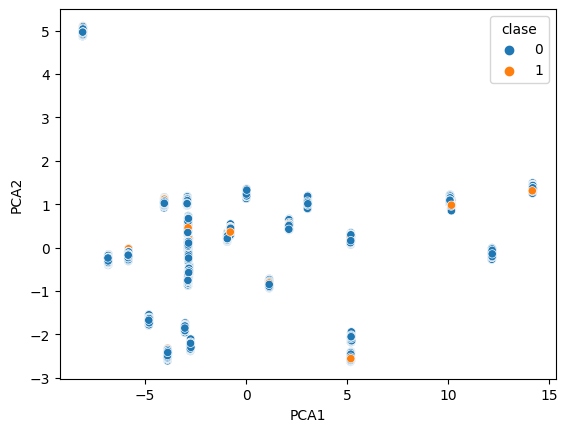

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

mapper_pca = DataFrameMapper([ 
    (['is_batter_lefty'], None), #
    (['bb_type'], [OneHotEncoder()]),
    (['is_pitcher_lefty'], None), #
    (['bearing'], [OneHotEncoder()]), #
    (['inning'], [StandardScaler()]), #
    (['outs_when_up'], None), #
    (['balls'], [StandardScaler()]), #
    (['strikes'], [StandardScaler()]), #
    (['plate_x'], [StandardScaler()]), #
    (['plate_z'], [StandardScaler()]), #   
    (['launch_angle'], [StandardScaler()]), # sacar los valores nulos para que sea válido
    (['launch_speed'], [StandardScaler()]),
    (['pitch_mph'], [StandardScaler()]),
    (['cover'], [OneHotEncoder()]),
    (['lf_dim'], [StandardScaler()]),
    (['cf_dim'], [StandardScaler()]),
    (['rf_dim'], [StandardScaler()]),
    (['lf_w'], [StandardScaler()]),
    (['cf_w'], [StandardScaler()]),
    (['rf_w'], None),
    #(['is_home_run'], None),
])

mapper_pca.fit(train)

pipe_pca1 = Pipeline([
    ('mapper', mapper_pca),
    ('imputer', SimpleImputer(strategy='mean')),
])


# preparar los datos
pipe_pca1.fit(train)
train_pca=pipe_pca1.transform(train)
train_pca= pd.DataFrame(train_pca, columns=mapper_pca.transformed_names_)

#aplicar la técnica de redución de dimensionalidades
pca_pipe = PCA(n_components=2, svd_solver="auto", random_state=42)
pca_pipe.fit(train_pca)
results = pca_pipe.fit_transform(train_pca)

#armar el dataframe con los datos obtenidos de la aplicación de PCA
results_red=pd.DataFrame({'PCA1':results[:,0], 'PCA2':results[:,1], 'clase':train.is_home_run})



#######################################################validation
#pipe_pca1.fit(validation)
#validation_pca=pipe_pca1.transform(validation)
#validation_pca= pd.DataFrame(validation_pca, columns=mapper_pca.transformed_names_)

#pca_pipe_v = PCA(n_components=2, svd_solver="auto", random_state=42)
#pca_pipe_v.fit(validation_pca)
#results_v = pca_pipe_v.fit_transform(validation_pca)

#armar el dataframe con los datos obtenidos de la aplicación de PCA
#results_red_v=pd.DataFrame({'PCA1':results_v[:,0], 'PCA2':results_v[:,1], 'clase':validation.is_home_run})

sns.scatterplot(x="PCA1", y="PCA2", hue='clase', data=results_red)

<Axes: >

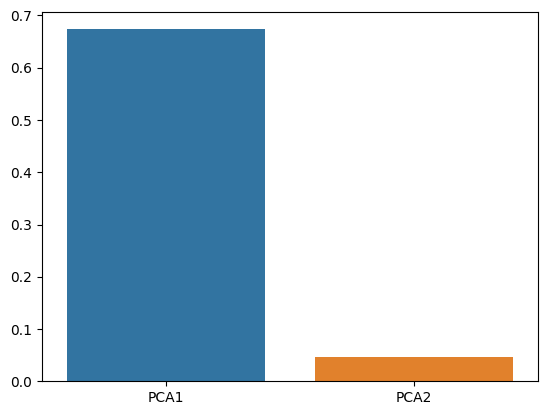

In [25]:
sns.barplot(x=["PCA1","PCA2"], y=pca_pipe.explained_variance_ratio_)

Como se puede observar en lo anterior, podemos ver que aplicando dicha técnica pasamos a tener solamente dos componenetes que representan el 72% de la información total del dataset. Como consecuencia, con las componentes calculadas, se ahorraría tiempo y se podrían utilizar modelos como regresión logística con mejores resultados. 

In [121]:
print(pca_pipe.explained_variance_ratio_)
print(pca_pipe.explained_variance_ratio_.sum())

[0.67361828 0.04722227]
0.7208405526761482


In [138]:
#pipel_red = Pipeline([
#    ('classifier', LogisticRegression(random_state=42)),
#])

#results_red_e=results_red
#results_red_e = results_red_e.drop(['clase'],axis=1)
#print(results_red_v.head())

#pipel_red.fit(results_red_e, results_red.clase)

#y_pred = pipel_red.predict(results_red_v)
#y_pred
#evaluate_model_pca(pipel_red, title='LR Simple Imputer')

#print(metrics.classification_report(results_red_v.clase, y_pred))

### Aplicación de técnica Umap

In [152]:
%matplotlib inline
import umap
import matplotlib.pyplot as plt

#Armar y ejecución del procedimiento necesario de la técnica
UMAP_Object=umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
ComponentValues=UMAP_Object.fit_transform(train_pca)
 
#Armar el dataframe con los datos obtenidos
ReducedData=pd.DataFrame(data=ComponentValues, columns=['Comp1','Comp2'])
print(ReducedData.head(10))

#plt.scatter(x="Comp1"[:,0], y="Comp2"[:,1], data=ReducedData)
#plt.title('UMAP embedding of random colours');

       Comp1      Comp2
0  19.144146   3.187220
1  10.242386   6.493171
2  18.948851  -3.703872
3   7.386363   1.120892
4   6.929351   6.542032
5  12.455861  -2.451300
6  13.077254  -0.603272
7  13.976715  -0.991627
8   4.233426  10.356662
9  15.021536   8.533885


# Evitar overfitting

# Valor para informar al cliente

In [ ]:
El valor que se debería informar al cliente debería ser 

# Diagramas de dispersión con aciertos y errores

In [ ]:
sns.scatterplot(x=train_nor[], y=, hue=train_nor.is_home_run, data=train_nor)